In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
raw_data = pd.read_csv('sales_orders.csv')
raw_data.DATE_CREATED = [datetime.strptime(x, '%d/%m/%Y %H:%M:%S') for x in raw_data.DATE_CREATED]

In [4]:
data = raw_data[['DATE_CREATED', 'SORDER_ID']].groupby('DATE_CREATED').count().reset_index()
data

,DATE_CREATED,SORDER_ID
0,2008-03-05,1
1,2008-03-31,2
2,2008-04-01,35
3,2008-04-02,22
4,2008-04-03,24
...,...,...
3507,2019-03-30,106
3508,2019-03-31,61
3509,2019-04-01,428
3510,2019-04-02,253


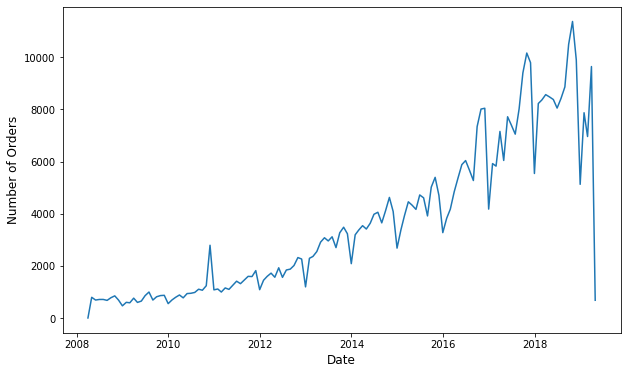

In [5]:
plt.figure(figsize=(10,6))
plt.plot(data.groupby(pd.Grouper(key='DATE_CREATED', freq='M')).sum())
plt.xlabel('Date',fontsize=12)
plt.ylabel('Number of Orders',fontsize=12)
plt.show()

In [6]:
data = data.loc[(data.DATE_CREATED >= '2008-04-01') & (data.DATE_CREATED < '2019-04-01')]
data.set_index('DATE_CREATED', inplace=True)
data.columns = ['Total_Orders']

In [7]:
data

,Total_Orders
DATE_CREATED,
2008-04-01,35
2008-04-02,22
2008-04-03,24
2008-04-04,28
2008-04-05,12
...,...
2019-03-27,416
2019-03-28,450
2019-03-29,401


In [8]:
df = data.Total_Orders

In [9]:
df

DATE_CREATED
2008-04-01     35
2008-04-02     22
2008-04-03     24
2008-04-04     28
2008-04-05     12
             ... 
2019-03-27    416
2019-03-28    450
2019-03-29    401
2019-03-30    106
2019-03-31     61
Name: Total_Orders, Length: 3507, dtype: int64

In [10]:
df.describe(include='all')

count    3507.000000
mean      137.901340
std       125.509001
min         1.000000
25%        37.000000
50%        91.000000
75%       210.000000
max       573.000000
Name: Total_Orders, dtype: float64

#### STATIONARITY

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
adfuller(df
         , autolag='AIC'
        )

(-1.798310071605763,
 0.38130101834833685,
 29,
 3477,
 {'1%': -3.4322321208787594,
  '5%': -2.8623716137556454,
  '10%': -2.567212682738095},
 37637.60483654415)

###### The above ADF test indicates that the data does not come from stationary process, as the test statistic is greater than the critical value.

#### TRANSFORMING THE DATASET TO FIT THE "STATIONARY" ASSUMPTIONS

In [13]:
#There are two common methods to remove trend and seasonality, they are:
#1. Differencing: by taking difference using time lag
#2. Decomposition: model both trend and seasonality, then remove them

#DIFFERENCING
df_diff = df.diff()
df_diff

DATE_CREATED
2008-04-01      NaN
2008-04-02    -13.0
2008-04-03      2.0
2008-04-04      4.0
2008-04-05    -16.0
              ...  
2019-03-27    -57.0
2019-03-28     34.0
2019-03-29    -49.0
2019-03-30   -295.0
2019-03-31    -45.0
Name: Total_Orders, Length: 3507, dtype: float64

In [14]:
df_diff.dropna(inplace=True)
adfuller(df_diff)

(-15.865635999546386,
 9.104746647658419e-29,
 28,
 3477,
 {'1%': -3.4322321208787594,
  '5%': -2.8623716137556454,
  '10%': -2.567212682738095},
 37629.09800023565)

###### The above is stationary at 1% critical value/99% confidence interval

/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


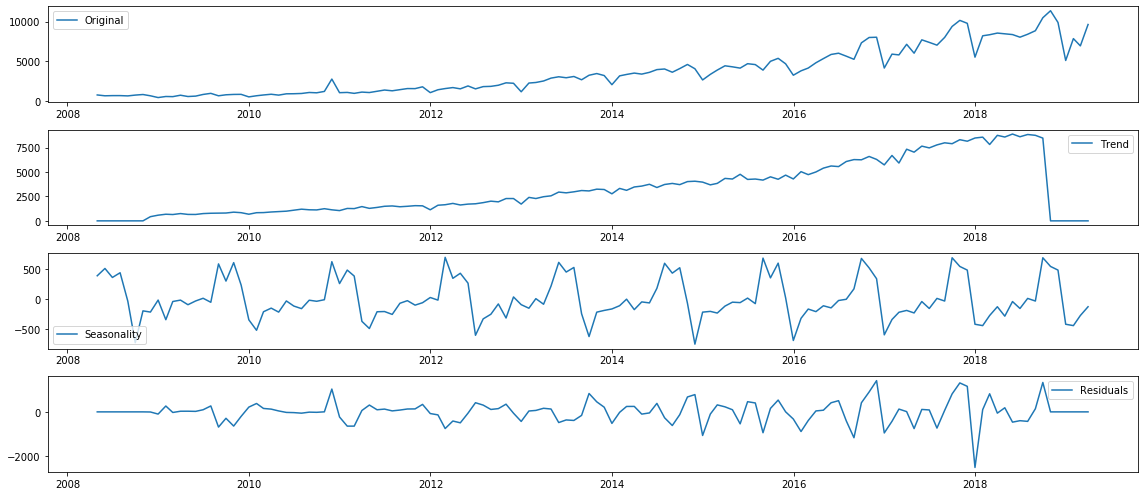

In [15]:
#DECOMPOSING (and plot data grouped by month)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


#------------------------------------------------
# Decomposition Plots
#------------------------------------------------

plt.figure(figsize=(16,7))
plt.subplot(411)
plt.plot(df.groupby(pd.Grouper(freq='M')).sum(), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend.groupby(pd.Grouper(freq='M')).sum(), label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal.groupby(pd.Grouper(freq='M')).sum(), label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual.groupby(pd.Grouper(freq='M')).sum(), label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [16]:
#Remove the trend and seasonality from the Time series by using residual values as decomposed dataset
df_log_decompose = residual
df_log_decompose.dropna(inplace=True)
adfuller(df_log_decompose)

(-8.791901369708585,
 2.228889470798282e-14,
 27,
 3115,
 {'1%': -3.43245102630828,
  '5%': -2.862468302843017,
  '10%': -2.5672641578701927},
 33156.117186082716)

###### The above is stationary at 1% critical value/99% confidence interval

# FORECASTING A TIME SERIES

### 1. SARIMA MODEL

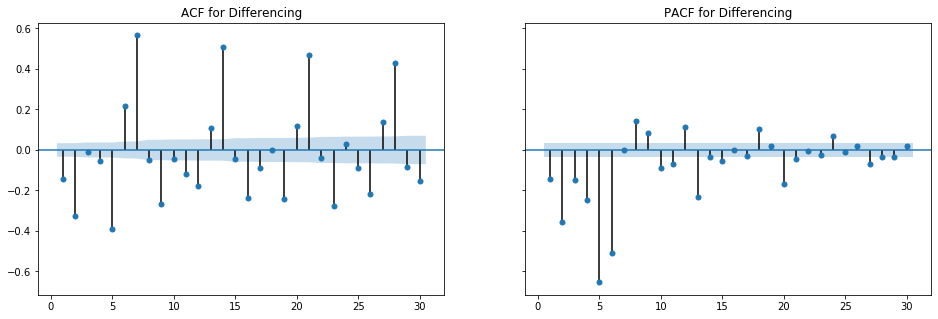

In [18]:
#First, SARIMA model will be used on the time series using differencing because...
#it is easier to convert predicted value back to original scale with differencing

#But first, number of lags/error term to use for the model must be determined.
import statsmodels.graphics.tsaplots as sgt

#Plotting ACF/PACF to determine number of lags/error term to use for the model
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
sgt.plot_acf(df_diff,  zero = False, lags = 30, title = 'ACF for Differencing' , ax=axs[0])
sgt.plot_pacf(df_diff, zero = False, lags = 30, title = 'PACF for Differencing', ax=axs[1])
plt.show()

• p: It is evident that the first 6 lags of PACF plot are significant since is well above the significance line before observing a non-significant lag. Hence p = 6.

• q: Just the first lag is above the significance line before observing a non-significant lag. Hence p = 2.

In [21]:
#Split the dataset into training and validation sets
split_time = int(df.shape[0] * 0.9)
train = df[:split_time]
test  = df[split_time:]
print(train.shape)
print(test.shape)

(3156,)
(351,)


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train
                       , order=(6,1,2)
                       , seasonal_order=(6,1,2,7)
                      ).fit(disp=-1)

sarima_model.summary()

/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Total_Orders   No. Observations:                 3507
Model:             SARIMAX(6, 1, 2)x(6, 1, 2, 7)   Log Likelihood              -18951.120
Date:                           Sun, 16 Aug 2020   AIC                          37936.241
Time:                                   23:38:07   BIC                          38040.965
Sample:                                        0   HQIC                         37973.616
                                          - 3507                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1969      0.059      3.319      0.001       0.081       0.313
ar.L2         -0.0088      0.018     -0.480      0.631      -0.045       0.027
ar.L3          0.0428      0.014      3.010      0.003       0.015       0.071
ar.L4         -0.0054      0.014     -0.375      0.708      -0.034       0.023
ar.L5         -0.1358      0.012    -11.181      0.000      -0.160      -0.112
ar.L6          0.4263      0.012     34.293      0.000       0.402       0.451
ma.L1         -0.9853      0.061    -16.249      0.000      -1.104      -0.866
ma.L2         -0.0131      0.060     -0.217      0.828      -0.132       0.105
ar.S.L7       -0.5871      0.363     -1.617      0.106      -1.298       0.124
ar.S.L14       0.3722      0.111      3.354      0.001       0.155       0.590
ar.S.L21       0.1490      0.043      3.460      0.001       0.065       0.233
ar.S.L28       0.0545      0.027      2.031      0.042       0.002       0.107
ar.S.L35      -0.0004      0.016     -0.027      0.978      -0.032       0.031
ar.S.L42      -0.0098      0.014     -0.698      0.485      -0.037       0.018
ma.S.L7       -0.0498      0.360     -0.138      0.890      -0.756       0.657
ma.S.L14      -0.8317      0.339     -2.450      0.014      -1.497      -0.166
sigma2      2936.3123     45.563     64.444      0.000    2847.010    3025.615
===================================================================================
Ljung-Box (Q):                      202.40   Jarque-Bera (JB):              2590.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.04   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 The results (mainly p-value) of the model coefficients are indicating that some of the lags and errors are insignificants (such as ar.L5, ar.L6, ma.L2) for this SARIMA model. It's best to rerun the model with few lags.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train
                       , order=(1,1,1)
                       , seasonal_order=(1,1,1,7)
                      ).fit(disp=-1)

sarima_model.summary()

/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      Total_Orders   No. Observations:                 3156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17283.902
Date:                           Sun, 16 Aug 2020   AIC                          34577.804
Time:                                   23:44:57   BIC                          34608.077
Sample:                                        0   HQIC                         34588.667
                                          - 3156                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0590      0.014      4.318      0.000       0.032       0.086
ma.L1         -0.9998      0.004   -278.009      0.000      -1.007      -0.993
ar.S.L7        0.4132      0.016     26.637      0.000       0.383       0.444
ma.S.L7       -0.8827      0.010    -90.199      0.000      -0.902      -0.863
sigma2      3420.8898     53.877     63.495      0.000    3315.293    3526.486
===================================================================================
Ljung-Box (Q):                     1299.56   Jarque-Bera (JB):              1986.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.32   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

All coefficients of the modified model are significant, given their p-values of 0.

In [37]:
#MODEL PERFORMANCE - ACCURACY METRIC AGAINST TRAINING SET
print('mae: ' + str(np.mean(np.abs(sarima_model.fittedvalues - train))) )

mae: 38.80463612601954
rmse: 58.457984101625044


Mean Absolute Error of 39 for a series whose mean is in 100's is not a bad model for our dataset here in my opinion. But how does the model perform against unseen (test) dataset?

/opt/anaconda3/envs/py3-TF2.0/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


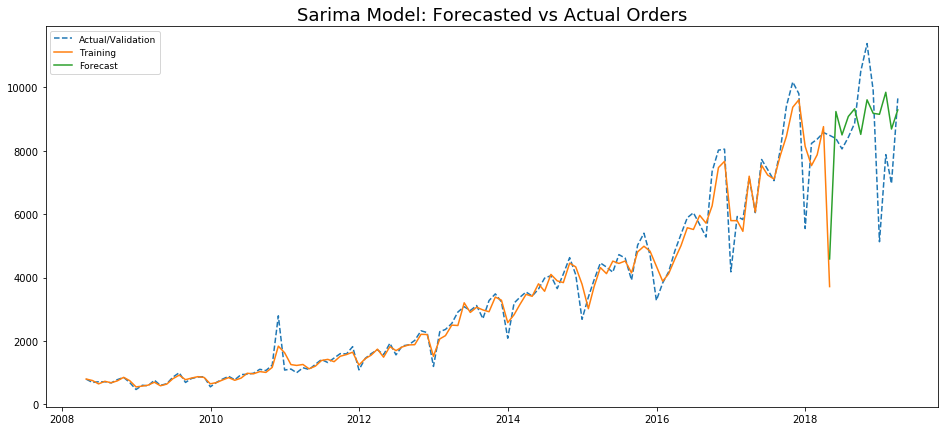

In [38]:
# Forecast
fc = sarima_model.get_forecast(len(test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series    = pd.Series(fc.predicted_mean.values,  index=test.index)


#------------------------------------------------
# Plot Forecast against Actuals
#------------------------------------------------

plt.figure(figsize=(16,7))
#plt.plot(df[:split_time].groupby(pd.Grouper(freq='M')).sum(), label='Actual', linestyle = '--', color='grey')
plt.plot(df.groupby(pd.Grouper(freq='M')).sum(), label='Actual/Validation', linestyle = '--')
plt.plot(sarima_model.fittedvalues.groupby(pd.Grouper(freq='M')).sum(), label='Training')
#plt.plot(test.groupby(pd.Grouper(freq='M')).sum(), label='validation')
plt.plot(fc_series.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')

plt.legend(loc='upper left', fontsize=9)
plt.title("Sarima Model: Forecasted vs Actual Orders", fontsize=18)
plt.show()

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(test.groupby(pd.Grouper(freq='M')).sum(), label='Validation')
plt.plot(fc_series.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')
plt.fill_between(lower_series_month.index, lower_series_month, upper_series_month, 
                 color='k', alpha=.15)

plt.legend(loc='upper left', fontsize=9)
plt.title("Zoom in: Forecasted vs Actual Orders", fontsize=18)
plt.show()

In [43]:
#VALIDATION
print('mae: ' + str(np.mean(np.abs(fc_series - test))) )

mae: 61.54987667131853


The model appears to perform worse when applied to unseen dataset, with Mean Absolute Error of 62.

##### 1.1 FINDING A BETTER SARIMA MODEL?

In [42]:
import pmdarima as pm
auto_sarima_model = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=6, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

auto_sarima_model.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=34737.978, BIC=34768.252, Time=2.568 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=35279.167, BIC=35291.276, Time=0.086 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=34962.134, BIC=34986.354, Time=1.227 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=34742.815, BIC=34767.034, Time=1.111 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=35277.465, BIC=35283.520, Time=0.053 seconds
Fit ARIMA(1,0,1)x(0,1,0,7) [intercept=True]; AIC=35141.111, BIC=35165.330, Time=1.568 seconds
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=34574.396, BIC=34610.725, Time=3.687 seconds
Fit ARIMA(1,0,1)x(1,1,0,7) [intercept=True]; AIC=34963.002, BIC=34993.277, Time=2.474 seconds
Fit ARIMA(1,0,1)x(2,1,1,7) [intercept=True]; AIC=34561.804, BIC=34604.188, Time=6.947 seconds
Fit ARIMA(1,0,1)x(2,1,0,7) [intercept=True]; AIC=34829.395, BIC=34865.724, Time=5.346 seconds
Fit ARIMA(1,0,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3156
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 7)   Log Likelihood              -17174.731
Date:                             Mon, 17 Aug 2020   AIC                          34365.462
Time:                                     00:20:08   BIC                          34413.900
Sample:                                          0   HQIC                         34382.842
                                            - 3156                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5835      0.189      3.095      0.002       0.214       0.953
ar.L1         -0.9164      0.012    -78.632      0.000      -0.939      -0.894
ma.L1          1.0995      0.015     71.736      0.000       1.069       1.130
ma.L2          0.0377      0.018      2.044      0.041       0.002       0.074
ma.L3         -0.2246      0.013    -17.192      0.000      -0.250      -0.199
ar.S.L7        0.4736      0.015     32.656      0.000       0.445       0.502
ma.S.L7       -0.9115      0.007   -122.729      0.000      -0.926      -0.897
sigma2      3190.4496     52.642     60.607      0.000    3087.274    3293.625
===================================================================================
Ljung-Box (Q):                      981.34   Jarque-Bera (JB):              1733.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.25   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

      comparing the AIC of auto sarima model (34365.462) to the base sarima model (34577.804), the results indicate that the auto_arima is a better model, since it has a lower AIC. Value for the LLR of the new model is also greater, which is an indication of a better model.

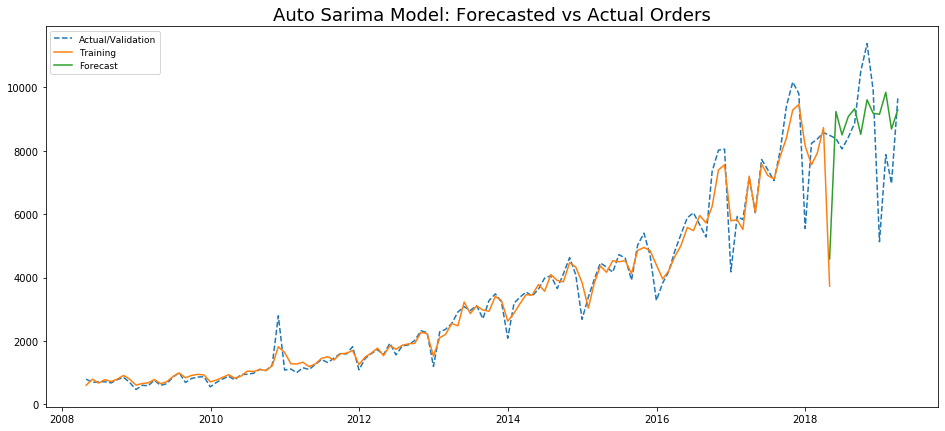

In [90]:
# Forecast
auto_pred = pd.Series(auto_sarima_model.predict_in_sample(), index= train.index)
auto_fc   = auto_sarima_model.predict(n_periods=len(test)) 

# Make as pandas series
auto_fc_series    = pd.Series(auto_fc,  index=test.index)


#------------------------------------------------
# Plot Forecast against Actuals
#------------------------------------------------
plt.figure(figsize=(16,7))
plt.plot(df.groupby(pd.Grouper(freq='M')).sum(), label='Actual/Validation', linestyle = '--')
plt.plot(auto_pred.groupby(pd.Grouper(freq='M')).sum(), label='Training')
#plt.plot(test.groupby(pd.Grouper(freq='M')).sum(), label='validation')
plt.plot(fc_series.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')

plt.legend(loc='upper left', fontsize=9)
plt.title("Auto Sarima Model: Forecasted vs Actual Orders", fontsize=18)
plt.show()

In [77]:
print('mae: ' + str(np.mean(np.abs(auto_fc_series - test))) )

mae: 60.584796616033714


There isn't much difference between the base and auto [s]arima model, with Mean Absolute Error of 62 and 61, respectively. 

### 2. LSTM RNN MODEL

In [91]:
#Similar to the first model, first step is to split data into training and validation sets:
split_time = int(data.shape[0] * 0.9)
time_train = data.index[:split_time]
x_train = data.Total_Orders.values[:split_time]
time_valid = data.index[split_time:]
x_valid = data.Total_Orders.values[split_time:]


window_size = 60 # 60 #time period to use as features for predicting the next value
batch_size = 60
shuffle_buffer_size = 1000 #No major impact, result is slightly worse [better] with lower [higher] value


In [92]:
# create time window function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) #expanding dimensions of the serie, this is because input shape will be specified on the conv1D
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # truncate to remove remainder to have equal size data
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:])) # split into inputs and target
    ds = ds.shuffle(shuffle_buffer) # shuffle ahead of training to prevent sequences bias
    return ds.batch(batch_size).prefetch(1) #batching data into smaller sets/clusters

In [93]:
# create prediction function
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [94]:
import tensorflow as tf

In [95]:
#Training the model: outline, optimizers, loss, early stopping and training

tf.keras.backend.clear_session() # clear any internal variables, to make it easy to experiment without model impacting later version of itself.
tf.random.set_seed(51)
np.random.seed(51)
window_size = 60 #60 TO UPDATE
batch_size = 100 #100 # TO UPDATE: explore different sizes bigger and smaller, to find appropriate one for this model.
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# start with 1D convolution tha will learn 60 filters, which will then output to 2 LSTMs with 60 cells each.
# before feeding into DNN with 30, 10, 1 neurons. finally a lambda layer to multiply x by 600 because of their range of 1 to 600
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=50, kernel_size=5, # 50
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(800, return_sequences=True), #800
  tf.keras.layers.LSTM(800, return_sequences=True), #800
  tf.keras.layers.Dense(300, activation="relu"), #300
  tf.keras.layers.Dense(300, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 600) #600
])

# using SGD so that I can set parameters to initialise things such as learning rate and momentum
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) 
model.compile(loss=tf.keras.losses.Huber(), # 'mean_squared_error',
              optimizer='adam',
              metrics=["mae"])

# set a maximum number of training epochs
max_epochs = 100
# setting an early stopping mechanism, with patience=3, to be a bit tolerant against random loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(train_set, epochs=max_epochs, callbacks=[early_stopping]) #set verbose=0 to ignore epoch to epoch output

Epoch 1/100
31/31 [==============================] - 51s 2s/step - loss: 227.1176 - mae: 227.7745
Epoch 2/100
31/31 [==============================] - 45s 1s/step - loss: 67.3576 - mae: 67.8572
Epoch 3/100
31/31 [==============================] - 44s 1s/step - loss: 35.8026 - mae: 36.2887
Epoch 4/100
31/31 [==============================] - 45s 1s/step - loss: 33.6323 - mae: 34.1232
Epoch 5/100
31/31 [==============================] - 49s 2s/step - loss: 29.4534 - mae: 29.9389
Epoch 6/100
31/31 [==============================] - 45s 1s/step - loss: 27.5649 - mae: 28.0481
Epoch 7/100
31/31 [==============================] - 46s 1s/step - loss: 27.0148 - mae: 27.4996
Epoch 8/100
31/31 [==============================] - 48s 2s/step - loss: 27.1539 - mae: 27.6416
Epoch 9/100
31/31 [==============================] - 46s 1s/step - loss: 26.3556 - mae: 26.8421
Epoch 10/100
31/31 [==============================] - 46s 1s/step - loss: 25.7180 - mae: 26.2024
Epoch 11/100
31/31 [=================

<Figure size 432x288 with 0 Axes>

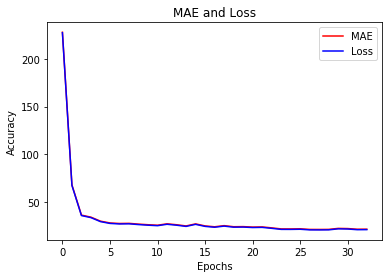

<Figure size 432x288 with 0 Axes>

In [96]:
#import matplotlib.image  as mpimg

# Retrieve results on training data
# sets for each training epoch

mae=history.history['mae']
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])
plt.figure()


<Figure size 432x288 with 0 Axes>

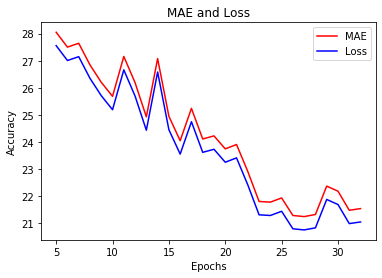

<Figure size 432x288 with 0 Axes>

In [97]:
epochs_zoom = epochs[5:]
mae_zoom = mae[5:]
loss_zoom = loss[5:]

#------------------------------------------------
# Zoomed MAE and Loss Plot
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

=================================================================================================

In [201]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size) #np.newaxis reshapes series to the input dimensions used by the model

# because the above return inputs and output, it must be specified for predict list to include only predictions
# predicting on validation set ONLY, could change to full dataset instead
#rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast = rnn_forecast[:, -1, 0]

In [202]:
rnn_fc = pd.Series(rnn_forecast[split_time - window_size:-1], index=time_valid)
rnn_fc

DATE_CREATED
2018-04-15    146.990448
2018-04-16    493.954742
2018-04-17    389.781158
2018-04-18    405.834106
2018-04-19    315.474243
                 ...    
2019-03-27    409.631348
2019-03-28    390.338257
2019-03-29    371.266571
2019-03-30     88.509979
2019-03-31     82.605881
Length: 351, dtype: float32

In [203]:
rnn_pred = rnn_forecast[:split_time - window_size]
rnn_pred = pd.Series(rnn_pred, index=time_train[window_size:split_time])
rnn_pred

DATE_CREATED
2008-06-11     38.693775
2008-06-12     40.778957
2008-06-13     36.166512
2008-06-16     34.661793
2008-06-17     37.228249
                 ...    
2018-04-10    382.473572
2018-04-11    348.480743
2018-04-12    382.108887
2018-04-13    350.414124
2018-04-14     83.880783
Length: 3096, dtype: float32

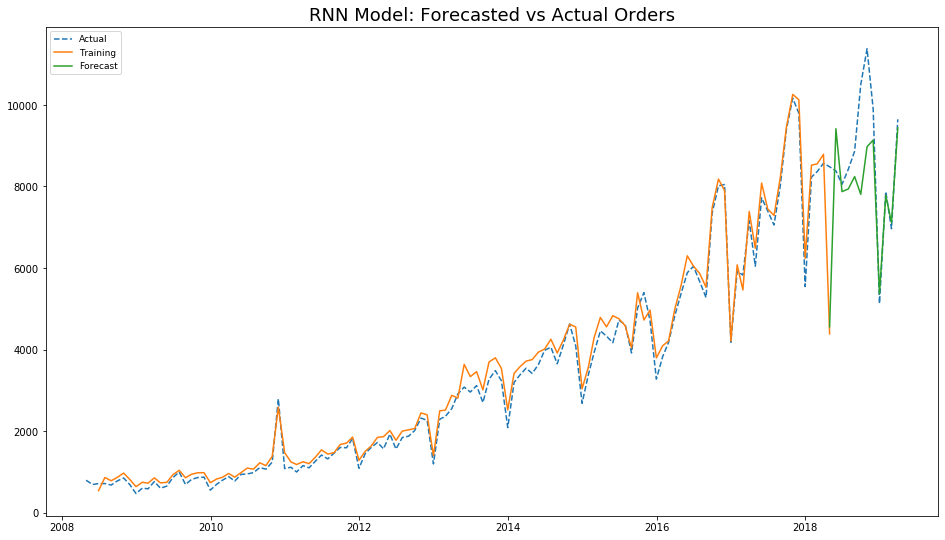

In [221]:
#------------------------------------------------
# Plot Forecast against Actuals
#------------------------------------------------

plt.figure(figsize=(16, 9))
plt.plot(data.groupby(pd.Grouper(freq='M')).sum(), label='Actual', linestyle = '--')
plt.plot(rnn_pred.groupby(pd.Grouper(freq='M')).sum(), label='Training')
plt.plot(rnn_fc.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')

plt.legend(loc='upper left', fontsize=9)
plt.title("RNN Model: Forecasted vs Actual Orders", fontsize=18)
plt.show()

In [205]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_fc).numpy()

51.467255

###### RNN model has provided a better forecast when applied on test dataset, with error (MAE) of 51. Whereas SARIMA model provided the lowest MAE of 61.

###### Difference in performance between the two models can be seen in charts below:

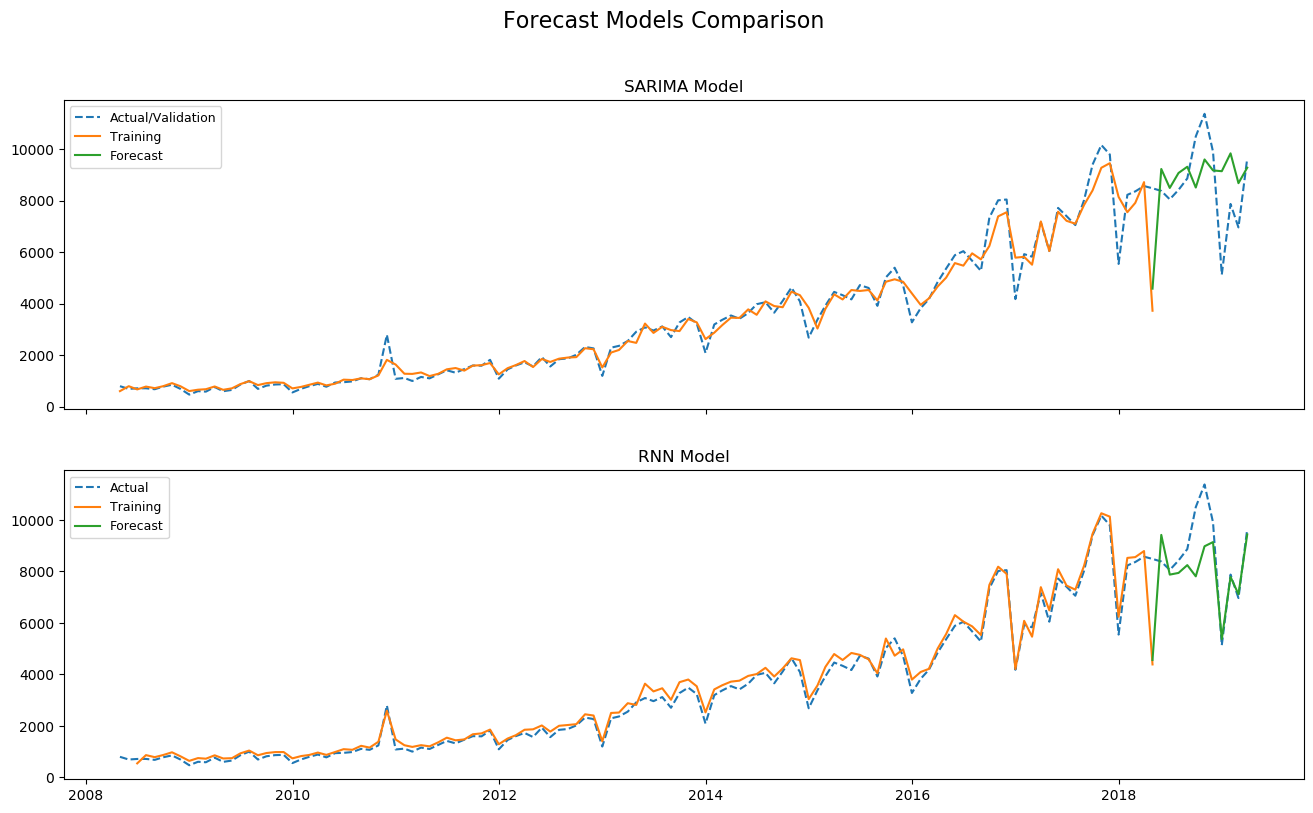

<Figure size 1152x648 with 0 Axes>

In [222]:
fig, axes = plt.subplots(2, 1, figsize=(16,9), dpi=100, sharex=True)

plt.suptitle('Forecast Models Comparison', fontsize=16)

# SARIMA MODEL
axes[0].plot(df.groupby(pd.Grouper(freq='M')).sum(), label='Actual/Validation', linestyle = '--')
axes[0].plot(auto_pred.groupby(pd.Grouper(freq='M')).sum(), label='Training')
axes[0].plot(fc_series.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].set_title("SARIMA Model", fontsize=12)

# LSTM MODEL
plt.figure(figsize=(16, 9))
axes[1].plot(data.groupby(pd.Grouper(freq='M')).sum(), label='Actual', linestyle = '--')
axes[1].plot(rnn_pred.groupby(pd.Grouper(freq='M')).sum(), label='Training')
axes[1].plot(rnn_fc.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].set_title("RNN Model", fontsize=12)

plt.show()

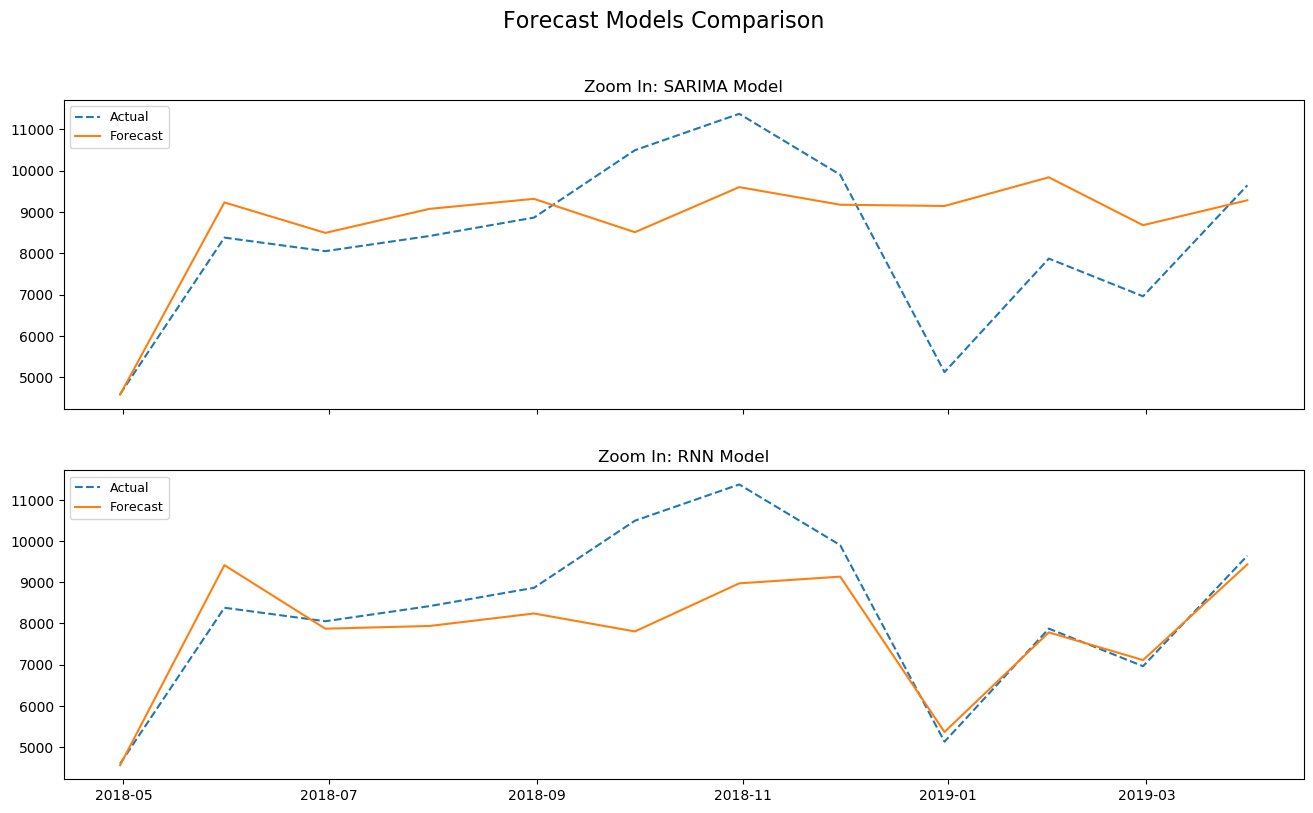

<Figure size 1152x648 with 0 Axes>

In [223]:
#------------------------------------------------
# Zoomed-in forecast plot
#------------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(16,9), dpi=100, sharex=True)

plt.suptitle('Forecast Models Comparison', fontsize=16)

# SARIMA MODEL
axes[0].plot(test.groupby(pd.Grouper(freq='M')).sum(), label='Actual', linestyle = '--')
axes[0].plot(fc_series.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].set_title("Zoom In: SARIMA Model", fontsize=12)

# LSTM RNN MODEL
plt.figure(figsize=(16, 9))
axes[1].plot(data[split_time:].groupby(pd.Grouper(freq='M')).sum(), label='Actual', linestyle = '--')
axes[1].plot(rnn_fc.groupby(pd.Grouper(freq='M')).sum(), label='Forecast')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].set_title("Zoom In: RNN Model", fontsize=12)

plt.show()